In [7]:
import pandas as pd
from fbprophet import Prophet

#### Prophet can make forecasts for time series with sub-daily observations by passing in a dataframe with timestamps in the ds column. The format of the timestamps should be YYYY-MM-DD HH:MM:SS - see the example csv here. When sub-daily data are used, daily seasonality will automatically be fit. Here we fit Prophet to data with 5-minute resolution (daily temperatures at Yosemite):

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/home/kkumar/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


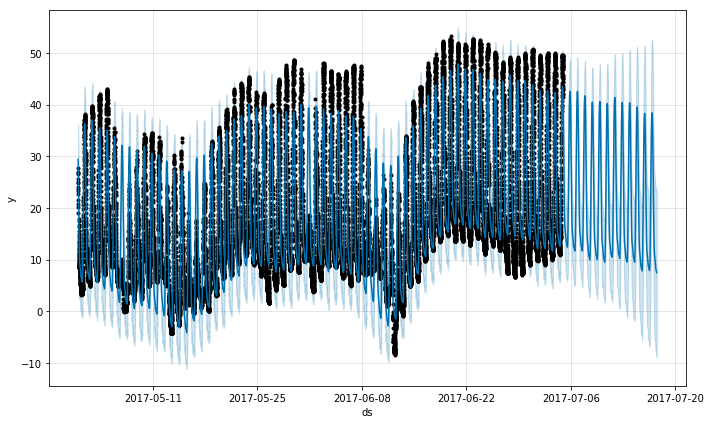

In [8]:
df = pd.read_csv('/home/kkumar/Workspace/FB_Prophet_Practice/data/example_yosemite_temps.csv')
m = Prophet(changepoint_prior_scale=0.01).fit(df)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

#### The components plot will also show daily seasonality:

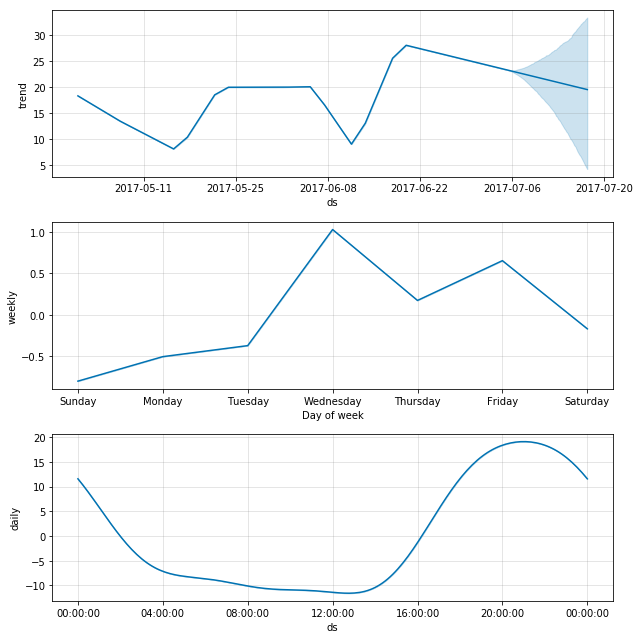

In [9]:
fig = m.plot_components(fcst)

### Data with regular gaps

#### Suppose the dataset above only had observations from 12a to 6a

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/home/kkumar/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


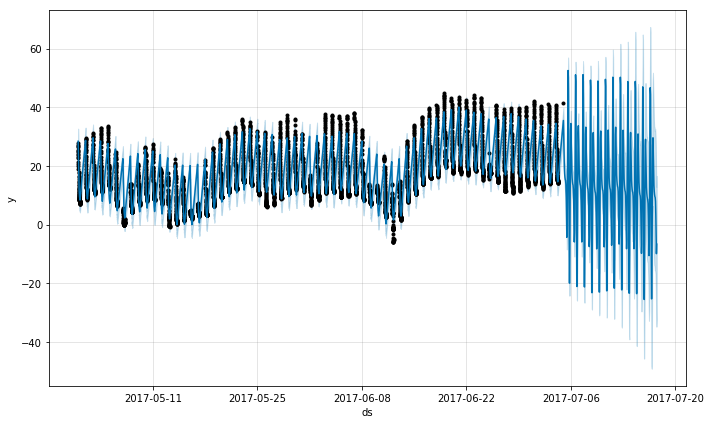

In [10]:
df2 = df.copy()
df2['ds'] = pd.to_datetime(df2['ds'])
df2 = df2[df2['ds'].dt.hour < 6]
m = Prophet().fit(df2)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

#### The forecast seems quite poor, with much larger fluctuations in the future than were seen in the history. The issue here is that we have fit a daily cycle to a time series that only has data for part of the day (12a to 6a). The daily seasonality is thus unconstrained for the remainder of the day and is not estimated well. The solution is to only make predictions for the time windows for which there are historical data. Here, that means to limit the future dataframe to have times from 12a to 6a:

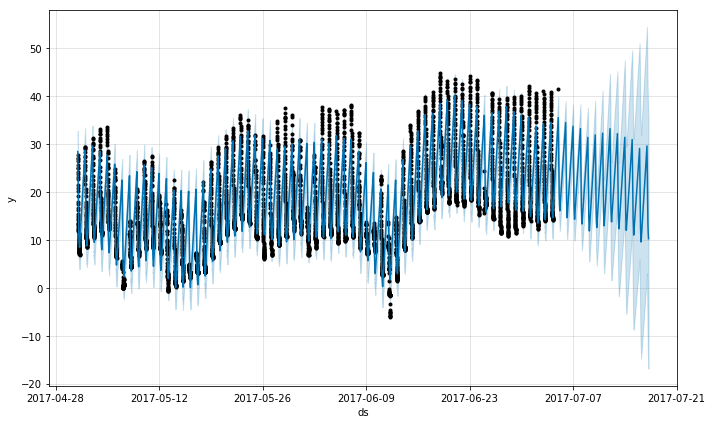

In [11]:
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour < 6]
fcst = m.predict(future2)
fig = m.plot(fcst)

#### The same principle applies to other datasets with regular gaps in the data. For example, if the history contains only weekdays, then predictions should only be made for weekdays since the weekly seasonality will not be well estimated for the weekends.

## Monthly data

#### You can use Prophet to fit monthly data. However, the underlying model is continuous-time, which means that you can get strange results if you fit the model to monthly data and then ask for daily forecasts. Here we forecast US retail sales volume for the next 10 years:

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/kkumar/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


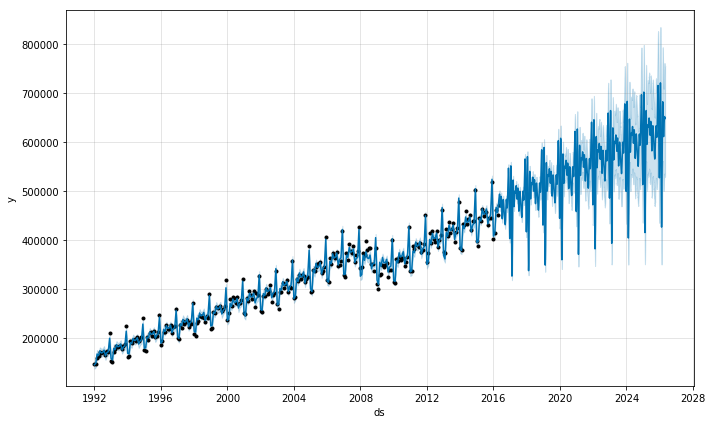

In [12]:
df = pd.read_csv('/home/kkumar/Workspace/FB_Prophet_Practice/data/example_retail_sales.csv')
m = Prophet(seasonality_mode='multiplicative').fit(df)
future = m.make_future_dataframe(periods=3652)
fcst = m.predict(future)
fig = m.plot(fcst)

#### This is the same issue from above where the dataset has regular gaps. When we fit the yearly seasonality, it only has data for the first of each month and the seasonality components for the remaining days are unidentifiable and overfit. This can be clearly seen by doing MCMC to see uncertainty in the seasonality:

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/kkumar/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/kkumar/anaconda3/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


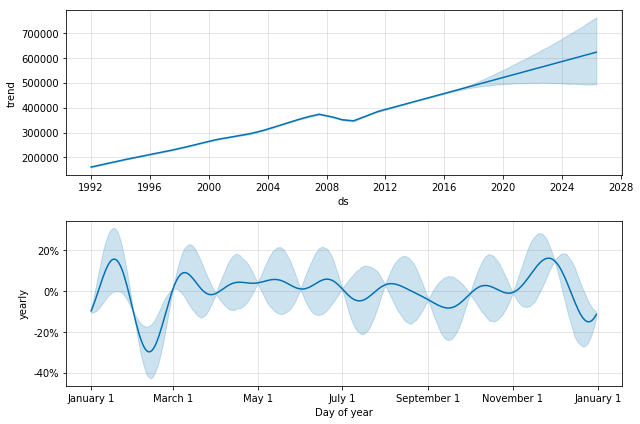

In [13]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(df)
fcst = m.predict(future)
fig = m.plot_components(fcst)

#### The seasonality has low uncertainty at the start of each month where there are data points, but has very high posterior variance in between. When fitting Prophet to monthly data, only make monthly forecasts, which can be done by passing the frequency into make_future_dataframe:

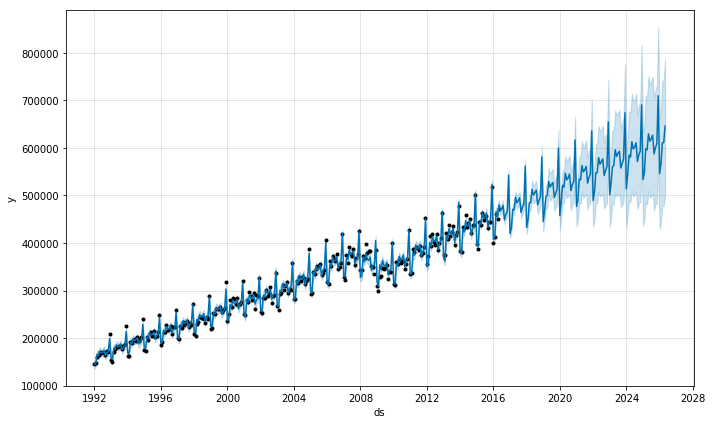

In [14]:
future = m.make_future_dataframe(periods=120, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)